# Hyperparameter Exploration
---

- Very short run time (for deep learning)
- Opportunity to systematically explore hyperparameter space

How to do this?

- Wrote recursive CNN layer model builder
- Specify n_layers, kernel_size, epochs, max_pooling step (i.e. max pool every pool_step layers)
- Also define regularisation (dropout or batch_normalisation)

Constraints:

- Fixed kernel size at each layer (not a typically unusal strategy)
- Didn't implement learning rate decay (although not needed - model overfits)
- Didn't implement variable number of FC layers
- Easy to create 10s of thousands of models - choose parameters carefully!

In [1]:
from undt_ai.synthetic_build import n_layer_model, layer_create
from undt_ai.tools import rmse
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from pathlib import Path
from undt_ai.load import load_pipeline, merge_load_pipeline
from undt_ai.tools import normal, rmse

## Example Usage of Model Builder
---

In [2]:
from undt_ai.synthetic_build import n_layer_model, layer_create
model = n_layer_model(n_layers=2, kernel_size=31, pool_step=2, batch_norm=False)
print(f'Num layers (inc batch_norm, pooling, etc.) = {len(model.layers)}')
model.summary() # 135k trainable params

Num layers (inc batch_norm, pooling, etc.) = 7
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 255, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 225, 64)           2048      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 64)           127040    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 97, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 97, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 6208)              0         
_________________________________________________________________
dense (Dense) 

In [3]:
from undt_ai.synthetic_build import n_layer_model, layer_create
model = n_layer_model(n_layers=4, kernel_size=31, pool_step=0, batch_norm=True, drop_layers=-1)
print(f'Num layers (inc batch_norm, pooling, etc.) = {len(model.layers)}')
model.summary() # 400k trainable params

Num layers (inc batch_norm, pooling, etc.) = 12
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 255, 1)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 225, 64)           2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 225, 64)           256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 195, 64)           127040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 195, 64)           256       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 165, 64)           127040    
_________________________________________________________________
batch_norma

In [4]:
from undt_ai.synthetic_build import n_layer_model, layer_create
model = n_layer_model(n_layers=21, kernel_size=11, pool_step=0, batch_norm=True, drop_layers=0)
model.summary() # 1million trainable params

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 255, 1)]          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 245, 64)           768       
_________________________________________________________________
batch_normalization_4 (Batch (None, 245, 64)           256       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 235, 64)           45120     
_________________________________________________________________
batch_normalization_5 (Batch (None, 235, 64)           256       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 225, 64)           45120     
_________________________________________________________________
batch_normalization_6 (Batch (None, 225, 64)           256 

# Parameter Space
---

In [5]:
import itertools
param_dict = {'n_layers':[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 17, 21],
        'kernel_size' : [3, 5, 7, 11, 15, 21, 31, 51, 71, 91],
        'pool_step' : [1, 2, 0],
        'drop_layers' : [0, -1],
        'batch_norm': [False, True]}
iter_params = itertools.product(*param_dict.values())
print(f'{len(list(iter_params))} combinations BUT many of these are invlaid')
print(f'~ 600 valid combinations')

1680 combinations BUT many of these are invlaid
~ 600 valid combinations


# Parameter Exploration
---

In [34]:
import pandas as pd
from pathlib import Path
data_folder = 'OneDrive - University of Bristol/Projects\Current projects/2018-20 Turing Fellowship/Chris data etc/Data'
root = Path.home() / data_folder
df = pd.read_pickle(root / 'synth_model_matrix_adam.pkl')

# How to filter out relevant models
filt1 = df['test_rmse'] != ''
filt2 = df['batch_norm'] == True
filt3 = df['drop_layers'] == 0
filt4 = df['n_layers'] < 17
filt = filt1 & filt2 & filt3 & filt4
df[filt].dropna().sort_values('test_rmse').head(15)

,n_layers,kernel_size,pool_step,drop_layers,batch_norm,test_loss,test_rmse,train_loss,train_rmse,val_loss,val_rmse,run_time,batch_size,best_epoch,epochs,trainable_params
310,4,51,0,0,True,0.0147258,0.117818,0.000987308,0.0311462,0.0180685,0.122215,517.703,128,587,600,634753
228,3,71,0,0,True,0.0157718,0.122716,0.00184065,0.0425207,0.0164923,0.11768,408.028,128,499,600,590017
570,7,31,0,0,True,0.0163131,0.124481,0.00199546,0.0441684,0.021705,0.133603,917.356,128,414,600,768961
399,5,51,0,0,True,0.0179975,0.12775,0.00153132,0.0387489,0.0228329,0.132988,610.247,128,436,600,840769
661,8,31,0,0,True,0.0175631,0.128852,0.00246241,0.0490559,0.0231333,0.136313,961.778,128,465,600,894337
481,6,31,0,0,True,0.0178222,0.13008,0.00305432,0.054777,0.0204401,0.131063,820.53,128,433,600,643585
832,11,21,0,0,True,0.0181648,0.131151,0.00223027,0.0468194,0.0223696,0.1366,1283.76,128,593,600,867265
742,9,21,0,0,True,0.0185352,0.133364,0.00442957,0.0657992,0.0220715,0.137865,1148.67,128,459,600,697153
217,3,51,2,0,True,0.0190439,0.134896,0.00164707,0.0401959,0.0217919,0.13872,298.972,128,381,400,423745
390,5,31,0,0,True,0.0204499,0.138447,0.00206959,0.0449929,0.0232146,0.140552,786.539,128,546,600,518209


In [8]:
# All models but not all ultimately relevant!
total_time = df[df['test_rmse'] != ''].dropna()['run_time'].sum()/3600
total_analysed = df[df['test_rmse'] != ''].dropna().shape[0]
print(f'{total_analysed} models have been run (and counting)')
print(f'Total run time = {total_time:.1f} hours (and counting)')

542 models have been run (and counting)
Total run time = 68.5 hours (and counting)


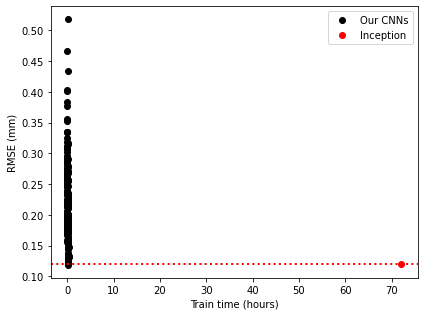

In [63]:
#PW - all data RMSE vs run time and all data vs trainable params
plt.figure(figsize=(6, 4.5))
filt0 = df['test_rmse'] != ''
filt1 = df['n_layers'] > 2
filt2 = df['kernel_size'] > 20
filt3 = df['batch_norm'] == True
filt = filt0 & filt2# & filt2 & filt3
inception_rmse = 1.2e-1
inception_train_time = 4320 * 60

run_time, test_rmse, trainable_params = df[filt]['run_time'], df[filt]['test_rmse'], df[filt]['trainable_params']

plt.plot(run_time / 3600, test_rmse, 'ko', mfc='k', label='Our CNNs') # next(marker_cycler)
plt.ylabel('RMSE (mm)'), plt.xlabel('Train time (hours)');
plt.plot(inception_train_time / 3600, inception_rmse, 'ro', mfc='r', label='Inception') # next(marker_cycler)
plt.axhline(inception_rmse, color='r', linewidth=2, ls=':')
#plt.axvline(inception_train_time / 3600, color='r', linewidth=2, ls=':', label='Inception')
#plt.plot(trainable_params, test_rmse, 'ko', mfc='w') # next(marker_cycler)
#plt.ylabel('RMSE (mm)'), plt.xlabel('Trainable parameters');

#plt.xlim(0, 0.4)
plt.legend( ncol=1, loc=1)
plt.tight_layout()
figpath = Path.home().joinpath(data_folder, 'figures')
plt.savefig(figpath / 'rmse_vs_train_time_zoom_out.png', dpi=400)

In [9]:
max_time = df[df['test_rmse'] != ''].dropna()['run_time'].max()/60
min_time = df[df['test_rmse'] != ''].dropna()['run_time'].min()/60
print(f'Longest model run time = {max_time:.1f} min')
print(f'Shortest model run time = {min_time:.1f} min')

Longest model run time = 37.4 min
Shortest model run time = 1.3 min


## Impact of Kernel Size and Number of Layers
---

- No pooling
- No Dropout
- Batch Normalisation after each layer (after activation)

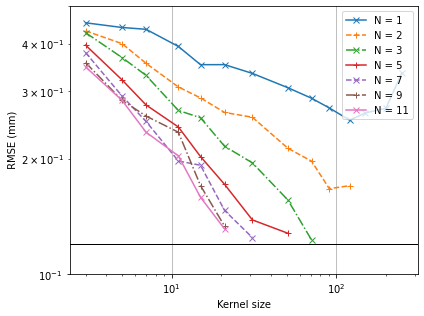

In [36]:
filt0 = df['test_rmse'] != ''
filt2 = df['pool_step'] == 0
filt3 = df['drop_layers'] == 0
filt4 = df['batch_norm'] == True
#filt5 = df['pool_step'] == 0

from cycler import cycle
plt.figure(figsize=(6, 4.5))
linestyle_cycler, marker_cycler = cycle(['-','--','-.']), cycle(['x','+'])
for n_layers in [1, 2, 3, 5, 7, 9, 11]:
    filt1 = df['n_layers'] == n_layers
    filt = filt0 & filt1 & filt2 & filt3 & filt4
    kernel_size, test_rmse = df[filt]['kernel_size'], df[filt]['test_rmse']
    plt.loglog(kernel_size, test_rmse, ls=next(linestyle_cycler), marker=next(marker_cycler), label=f'N = {n_layers}', mfc='w') # next(marker_cycler)
plt.legend( ncol=1, loc=1)
plt.ylim(1e-1, 5e-1), plt.grid()
plt.axhline(1.2e-1, color='k', linewidth=1)
plt.ylabel(' RMSE (mm)'), plt.xlabel('Kernel size');
plt.tight_layout()
figpath = Path.home().joinpath(data_folder, 'figures')
plt.savefig(figpath / 'grid_search.png', dpi=400)

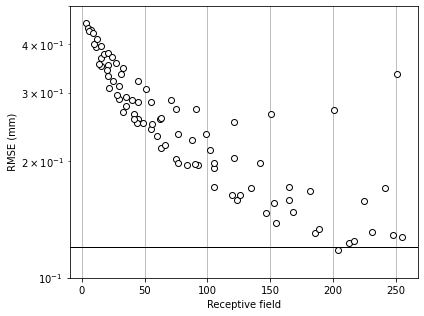

In [37]:
filt0 = df['test_rmse'] != ''
filt2 = df['pool_step'] == 0
filt3 = df['drop_layers'] == 0
filt4 = df['batch_norm'] == True
#filt5 = df['pool_step'] == 0

from cycler import cycle
plt.figure(figsize=(6, 4.5))
linestyle_cycler, marker_cycler = cycle(['-','--','-.']), cycle(['x','+'])
for n_layers in list(range(1, 10)) + [11,15]:
    filt1 = df['n_layers'] == n_layers
    filt = filt0 & filt1 & filt2 & filt3 & filt4
    kernel_size, test_rmse = df[filt]['kernel_size'], df[filt]['test_rmse']
    plt.semilogy(kernel_size * n_layers, test_rmse, 'ko', mfc='w') # next(marker_cycler)
plt.ylim(1e-1, 5e-1), plt.grid()
plt.axhline(1.2e-1, color='k', linewidth=1)
plt.ylabel(' RMSE (mm)'), plt.xlabel('Receptive field');
plt.tight_layout()
figpath = Path.home().joinpath(data_folder, 'figures')
plt.savefig(figpath / 'receptive_field.png', dpi=400)

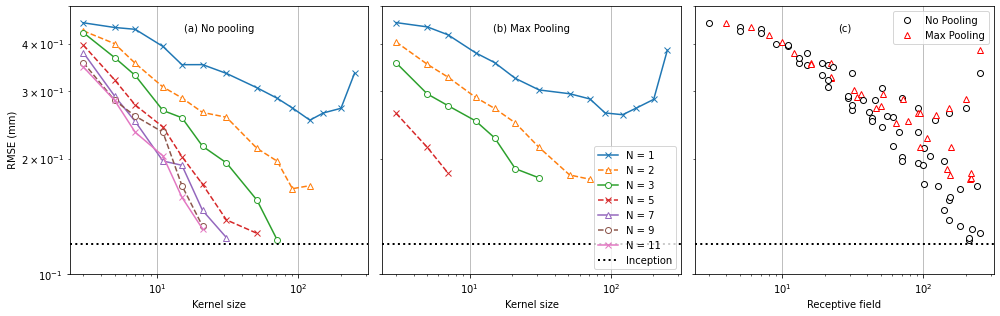

In [13]:
from cycler import cycle
df.loc[1224, 'test_rmse'] = ''
filt0 = df['test_rmse'] != ''
filt2 = df['pool_step'] == 0
filt3 = df['drop_layers'] == 0
filt4 = df['batch_norm'] == True
filt5 = df['pool_step'] == 1

fig, axes = plt.subplots(1, 3, figsize=(14, 4.5), sharey=True)

linestyle_cycler, marker_cycler = cycle(['-','--']), cycle(['x','^', 'o'])
for n_layers in [1, 2, 3, 5, 7, 9, 11]:
    filt1 = df['n_layers'] == n_layers
    filt = filt0 & filt1 & filt2 & filt3 & filt4
    filtp = filt0 & filt1 & filt5 & filt3 & filt4
    kernel_size, test_rmse = df[filt]['kernel_size'].values, df[filt]['test_rmse'].values
    rf = (kernel_size-1) * n_layers + 1
    
    m = next(marker_cycler)
    ls = next(linestyle_cycler)
    axes[0].loglog(kernel_size, test_rmse, ls=ls, marker=m, mfc='w') # next(marker_cycler)
    axes[2].semilogy(rf, test_rmse, 'ko', mfc='w') # next(marker_cycler)
    
    
    kernel_size, test_rmse = df[filtp]['kernel_size'].values, df[filtp]['test_rmse'].values
    rf = (kernel_size+1) + 2 * kernel_size * ( n_layers - 1)
    rf = kernel_size *(2**n_layers - 1) + 1
    axes[1].loglog(kernel_size, test_rmse, mfc='w', marker=m, ls=ls, label=f'N = {n_layers}') # next(marker_cycler)
    axes[2].loglog(rf, test_rmse, 'r^', mfc='w') # next(marker_cycler)
    
axes[0].set_ylim(1e-1, 5e-1), plt.grid()
axes[0].set_ylabel(' RMSE (mm)'), plt.xlabel('Kernel size')
axes[1].set_xlim(axes[0].get_xlim())

for ax, xlabel, title in zip(axes, ['Kernel size', 'Kernel size', 'Receptive field'], 
                      ['(a) No pooling', '(b) Max Pooling', '(c)']):
    ax.set_xlabel(xlabel)
    ax.grid('on')
    ax.axhline(1.2e-1, color='k', linewidth=2, ls=':', label='Inception')
    
    ax.text(0.5, 0.92,title,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
    
axes[1].legend( ncol=1, loc=4)
axes[2].legend(['No Pooling', 'Max Pooling'])    
fig.tight_layout()
figpath = Path.home().joinpath(data_folder, 'figures')
fig.savefig(figpath / 'kernel_pool.png', dpi=400)




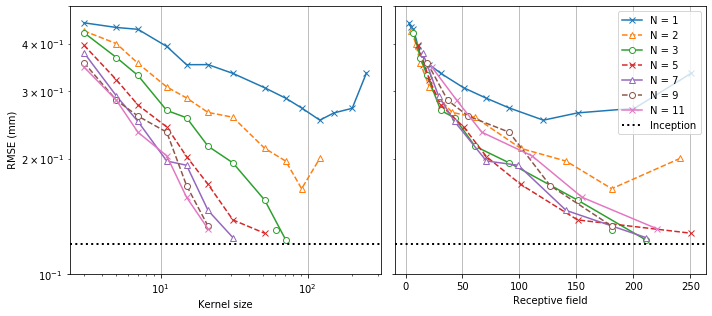

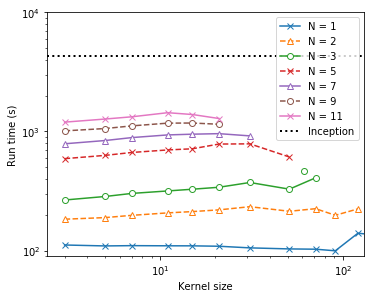

In [118]:
from cycler import cycle

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True)

linestyle_cycler, marker_cycler = cycle(['-','--']), cycle(['x','^', 'o'])
for n_layers in [1, 2, 3, 5, 7, 9, 11]:
    filt1 = df['n_layers'] == n_layers
    filt = filt0 & filt1 & filt2 & filt3 & filt4
    kernel_size, test_rmse = df[filt]['kernel_size'].values, df[filt]['test_rmse'].values
    m = next(marker_cycler)
    ls = next(linestyle_cycler)
    axes[0].loglog(kernel_size, test_rmse, ls=ls, marker=m, mfc='w') # next(marker_cycler)
    axes[1].semilogy((kernel_size-1) * n_layers + 1, test_rmse, '-', mfc='w', marker=m, ls=ls, label=f'N = {n_layers}') # next(marker_cycler)
    
axes[0].set_ylim(1e-1, 5e-1), plt.grid()
axes[0].axhline(1.2e-1, color='k', linewidth=2, ls=':', label='Inception')
axes[1].axhline(1.2e-1, color='k', linewidth=2, ls=':', label='Inception')
axes[0].set_ylabel(' RMSE (mm)'), plt.xlabel('Kernel size')
axes[1].legend( ncol=1, loc=1)

for ax, xlabel in zip(axes, ['Kernel size', 'Receptive field']):
    ax.set_xlabel(xlabel)
    ax.grid('on')
    
fig.tight_layout()
figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')
fig.savefig(figpath / 'kernel_receptive_field.png', dpi=400)


plt.figure(figsize=(5.25, 4.25))

linestyle_cycler, marker_cycler = cycle(['-','--']), cycle(['x','^', 'o'])
for n_layers in [1, 2, 3, 5, 7, 9, 11]:
    m = next(marker_cycler)
    ls = next(linestyle_cycler)
    filt1 = df['n_layers'] == n_layers
    filt = filt0 & filt1 & filt2 & filt3 & filt4
    kernel_size, test_rmse, run_time = df[filt]['kernel_size'].values, df[filt]['test_rmse'].values, df[filt]['run_time'].values
    rf = (kernel_size-1) * n_layers + 1
    plt.loglog(kernel_size, run_time, ls=ls, marker=m,  mfc='w', label=f'N = {n_layers}') # next(marker_cycler)
#plt.ylim(1e-1, 5e-1), plt.grid()
plt.axhline(4320, color='k', linewidth=2, ls=':', label='Inception')

plt.axhline(1.2e-1, color='k', linewidth=1)
plt.xlabel('Kernel size')
plt.ylabel('Run time (s)')
plt.xlim(None, 130)
plt.ylim(90, 10000)
plt.legend()
plt.tight_layout()
plt.savefig(figpath / 'kernel_runtime.png', dpi=400)


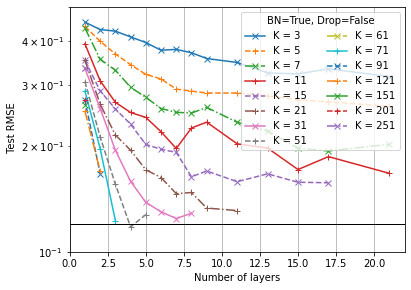

In [14]:
plt.figure(figsize=(6, 4.5))
linestyle_cycler, marker_cycler = cycle(['-','--','-.']), cycle(['x','+'])
for kernel_size in np.unique(df['kernel_size']):
    filt1 = df['kernel_size'] == kernel_size
    filt = filt0 & filt1 & filt2 & filt3 & filt4
    n_layers, test_rmse = df[filt]['n_layers'], df[filt]['test_rmse']
    plt.semilogy(n_layers, test_rmse, ls=next(linestyle_cycler), marker=next(marker_cycler), label=f'K = {kernel_size}', mfc='w') # next(marker_cycler)
plt.legend(title=f'BN={True}, Drop={False}', ncol=2, loc=1)
plt.ylim(1e-1, 5e-1), plt.grid()
plt.axhline(1.2e-1, color='k', linewidth=1)
plt.ylabel(' Test RMSE'), plt.xlabel('Number of layers');

## Regularisation Comparison
---

- No pooling
- No regularisation vs. batch norm vs dropout on final layer only (0.5)

In [15]:
filt0 = df['test_rmse'] != ''
filt2 = df['pool_step'] == 0

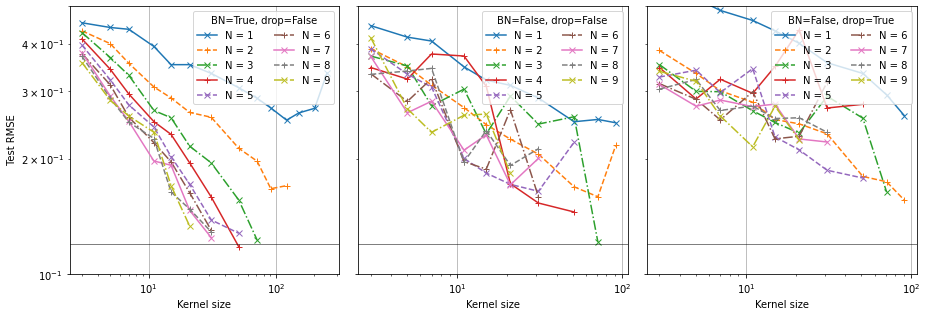

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), sharey=True)
for bn, drop, ax in zip([True, False, False], [False, False, True], axes):
    linestyle_cycler, marker_cycler = cycle(['-','--','-.']), cycle(['x','+'])
    for n_layers in range(1, 10):
        filt1 = df['n_layers'] == n_layers
        filt3 = df['drop_layers'] == -1 if drop else df['drop_layers'] == 0
        filt4 = df['batch_norm'] == bn
        filt = filt0 & filt1 & filt2 & filt3 & filt4
        kernel_size = df[filt]['kernel_size']
        test_rmse = df[filt]['test_rmse']
        ax.loglog(kernel_size, test_rmse, ls=next(linestyle_cycler), marker=next(marker_cycler), label=f'N = {n_layers}', mfc='w') # next(marker_cycler)
    ax.legend(title=f'BN={bn}, drop={drop}', ncol=2, loc=1)
    ax.set_ylim(1e-1, 5e-1), ax.grid()
    ax.set_xlabel('Kernel size')
    ax.axhline(1.2e-1, color='k', lw=0.5)
axes[0].set_ylabel(' Test RMSE')
fig.tight_layout()

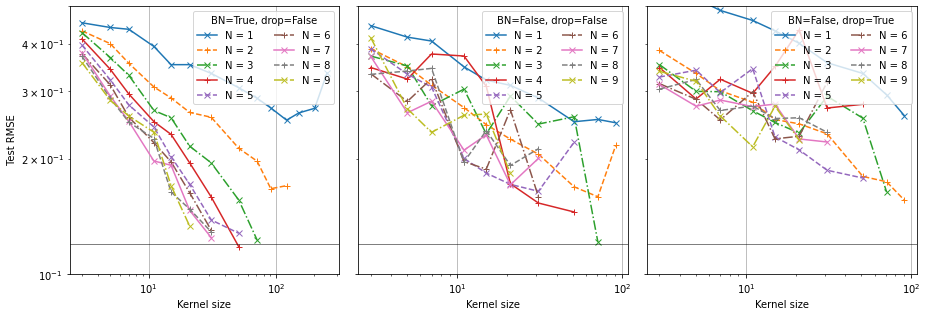

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), sharey=True)
for bn, drop, ax in zip([True, False, False], [False, False, True], axes):
    linestyle_cycler, marker_cycler = cycle(['-','--','-.']), cycle(['x','+'])
    for n_layers in range(1, 10):
        filt1 = df['n_layers'] == n_layers
        filt3 = df['drop_layers'] == -1 if drop else df['drop_layers'] == 0
        filt4 = df['batch_norm'] == bn
        filt = filt0 & filt1 & filt2 & filt3 & filt4
        kernel_size = df[filt]['kernel_size']
        test_rmse = df[filt]['test_rmse']
        ax.loglog(kernel_size, test_rmse, ls=next(linestyle_cycler), marker=next(marker_cycler), label=f'N = {n_layers}', mfc='w') # next(marker_cycler)
    ax.legend(title=f'BN={bn}, drop={drop}', ncol=2, loc=1)
    ax.set_ylim(1e-1, 5e-1), ax.grid()
    ax.set_xlabel('Kernel size')
    ax.axhline(1.2e-1, color='k', lw=0.5)
axes[0].set_ylabel(' Test RMSE')
fig.tight_layout()

## Pooling Comparison
---

- No dropout, batch normalisation on each layer
- No pooling vs. pooling after every layer vs. pooling after every other layer


In [18]:
filt0 = df['test_rmse'] != ''
filt3 = df['drop_layers'] == 0
filt4 = df['batch_norm'] == True

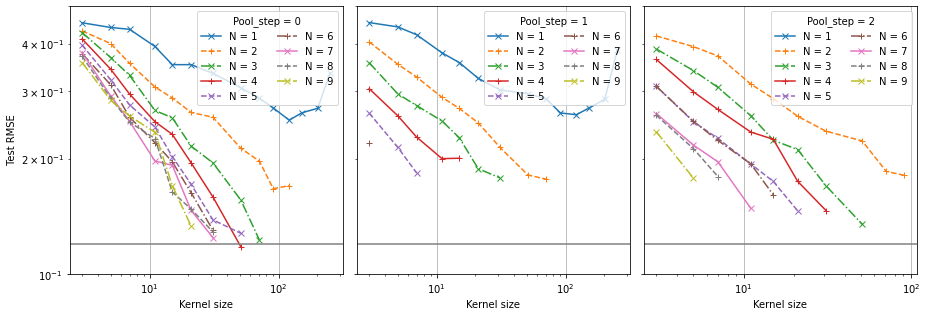

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), sharey=True)
for pool_step, ax in zip([0, 1, 2], axes):
    linestyle_cycler, marker_cycler = cycle(['-','--','-.']), cycle(['x','+'])
    for n_layers in range(1, 10):
        filt1 = df['n_layers'] == n_layers
        filt2 = df['pool_step'] == pool_step
        filt = filt0 & filt1 & filt2 & filt3 & filt4
        kernel_size = df[filt]['kernel_size']
        test_rmse = df[filt]['test_rmse']
        ax.loglog(kernel_size, test_rmse, ls=next(linestyle_cycler), marker=next(marker_cycler), label=f'N = {n_layers}', mfc='w') # next(marker_cycler)
    ax.legend(title=f'Pool_step = {pool_step}', ncol=2, loc=1)
    ax.set_ylim(1e-1, 5e-1), ax.grid()
    ax.set_xlabel('Kernel size')
    ax.axhline(1.2e-1, color='0.5')
axes[0].set_ylabel(' Test RMSE')
fig.tight_layout()

## Impact of Trainable Params
---

- No dropout and batch normalisation on each layer
- No pooling


In [20]:
filt0 = df['test_rmse'] != ''
filt1 = df['batch_norm'] == True
filt =  filt0 & filt1# filt0 if i ==0 else (df['batch_norm'] == True) & filt0
#label = f'batch_norm={i == 1}' if i==1 else ''
plt.loglog(df[filt]['trainable_params'], df[filt]['test_rmse'], '.', c='k', mfc='w', label=label)
plt.axvline(5e5, c='k', lw=1, ls='--')
plt.axvline(1e6, c='k', lw=1, ls='--', label='Top 10')
plt.legend()
plt.xlabel('Trainable parameters')
plt.ylabel('Test RMSE');

NameError: name 'label' is not defined

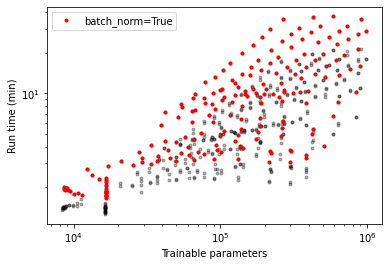

In [45]:
filt0 = df['test_rmse'] != ''
for i, c, a in zip(range(2), ['k', 'r'], [0.3, 1]):
    filt = filt0 if i ==0 else (df['batch_norm'] == True) & filt0
    label = f'batch_norm={i == 1}' if i==1 else ''
    plt.loglog(df[filt]['trainable_params'], df[filt]['run_time']/60, '.', c=c, alpha=a, label=label)
plt.legend()
plt.xlabel('Trainable parameters')
plt.ylabel('Run time (min)');

# Repetition of Best Models
---

- Repeat each of the best 15 models
- Repeat 5 times/per model
- Report combined accuracy and rmse spread


In [24]:
root = Path.home() / data_folder
df = pd.read_pickle(root / 'synth_model_matrix_adam_best.pkl')
total_time = df[df['test_rmse'] != ''].dropna()['run_time'].sum()/3600
total_analysed = df[df['test_rmse'] != ''].dropna().shape[0]
print(f'{total_analysed} models have been run (and counting)')
print(f'Total run time = {total_time:.1f} hours (and counting)')

71 models have been run (and counting)
Total run time = 10.1 hours (and counting)


In [25]:
# Top 5 models
df = pd.read_pickle(root / 'synth_model_matrix_adam.pkl')
filt = df['test_rmse'] != ''
df[filt].sort_values('test_rmse').head(5)

,n_layers,kernel_size,pool_step,drop_layers,batch_norm,test_loss,test_rmse,train_loss,train_rmse,val_loss,val_rmse,run_time,batch_size,best_epoch,epochs,trainable_params
310,4,51,0,0,True,0.0147258,0.117818,0.000987308,0.0311462,0.0180685,0.122215,517.703,128,587,600,634753
229,3,71,0,0,False,0.015428,0.12122,0.0024064,0.0485438,0.0207993,0.132823,296.656,128,304,600,589249
228,3,71,0,0,True,0.0157718,0.122716,0.00184065,0.0425207,0.0164923,0.11768,408.028,128,499,600,590017
570,7,31,0,0,True,0.0163131,0.124481,0.00199546,0.0441684,0.021705,0.133603,917.356,128,414,600,768961
399,5,51,0,0,True,0.0179975,0.12775,0.00153132,0.0387489,0.0228329,0.132988,610.247,128,436,600,840769


In [28]:
# Top model with 5 repeats
df = pd.read_pickle(root / 'synth_model_matrix_adam_best.pkl')

df.head(5)

,index,n_layers,kernel_size,pool_step,drop_layers,batch_norm,test_loss,test_rmse,train_loss,train_rmse,val_loss,val_rmse,run_time,batch_size,best_epoch,epochs,trainable_params,run
0,0,4,51,0,0,True,0.0147258,0.117818,0.000987308,0.0311462,0.0180685,0.122215,517.703,128,587,600,634753,0
1,0,4,51,0,0,True,0.0158601,0.122484,0.00144644,0.0377088,0.0180758,0.122217,479.261,128,579,600,634753,1
2,0,4,51,0,0,True,0.0152083,0.119731,0.000932822,0.0302279,0.0185524,0.123398,471.097,128,546,600,634753,2
3,0,4,51,0,0,True,0.0143976,0.116778,0.00104663,0.0320962,0.0186974,0.123611,474.139,128,581,600,634753,3
4,0,4,51,0,0,True,0.0154096,0.120647,0.00109043,0.0327891,0.0177399,0.121675,472.868,128,590,600,634753,4


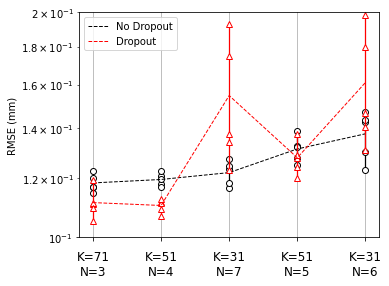

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5.5, 4.))

df = pd.read_pickle(root / 'synth_model_matrix_adam_best.pkl')
figpath = Path.home().joinpath(data_folder, 'figures')

filt0 = df['test_rmse'] != ''
filt2 = df['batch_norm'] == True
filt3 = df['pool_step'] == 0
filt = filt0 & filt2  & filt3

df = df[filt].sort_values(['kernel_size']).reset_index(drop=True)
df['test_rmse'] = df['test_rmse'].astype('float')
comb_rmse = []
df_mean = df.groupby('index').mean().sort_values('test_rmse')

for df, c, m, drop in zip([pd.read_pickle(root / 'synth_model_matrix_adam_best.pkl'), 
            pd.read_pickle(root / 'synth_model_matrix_adam_best_drop.pkl')], 
                    ['k', 'r'], ['o', '^'], ['No Dropout', 'Dropout']):
    filt0 = df['test_rmse'] != ''
    filt2 = df['batch_norm'] == True
    filt3 = df['pool_step'] == 0
    filt = filt0 & filt2  & filt3

    df = df[filt].sort_values(['kernel_size']).reset_index(drop=True)
    df['test_rmse'] = df['test_rmse'].astype('float')
    
    comb = []
    labels = []


    for idx, index in enumerate(df_mean.index.values[:5]):
        
        try:
            df_tmp = df[df['index'] == index]
            test_rmse = df_tmp['test_rmse']
            comb_rmse = np.nanmean(test_rmse**2)**0.5
            comb.append(comb_rmse)
            n_layers, kernel_size = df_tmp[['n_layers', 'kernel_size']].values[0]
            label = f'K={kernel_size}\nN={n_layers}'
            labels.append(label)
            plt.semilogy([idx+1, idx+1], [test_rmse.min(),  test_rmse.max()], '-', c=c, lw=1.25)
            plt.semilogy(np.ones_like(test_rmse) * (idx+1), test_rmse, m, mfc='w', c=c)
        except IndexError:
            print('Index Error')
        
    plt.semilogy(range(1, idx+2), comb, c=c, label=drop, ls='--', lw=1)
    
plt.legend()
plt.xticks([1, 2, 3,4, 5])
plt.ylabel('RMSE (mm)')
plt.gca().set_xticklabels(labels, size=12)
plt.gca().tick_params(axis='x', which='major', pad=10)
plt.grid()
plt.tight_layout()
plt.ylim(1e-1, 2e-1)
#figpath = Path.home().joinpath('Dropbox/Projects/undt-ai/figures/')

plt.savefig(figpath / 'optimization.png', dpi=400)

# Older plots

In [32]:
plt.figure(figsize=(5.5, 4.))

df = pd.read_pickle(root / 'results/synth_model_matrix_adam_best.pkl')

filt0 = df['test_rmse'] != ''
filt2 = df['batch_norm'] == True
filt3 = df['pool_step'] == 0
filt = filt0 & filt2  & filt3

df = df[filt].sort_values(['kernel_size']).reset_index()
df['test_rmse'] = df['test_rmse'].astype('float')
comb_rmse = []
df_mean = df.groupby('index').mean().sort_values('test_rmse')

comb = []
labels = []
for idx, index in enumerate(df_mean.index.values[:5]):
    df_tmp = df[df['index'] == index]
    test_rmse = df_tmp['test_rmse']
    comb_rmse = np.nanmean(test_rmse**2)**0.5
    comb.append(comb_rmse)
    n_layers, kernel_size = df_tmp[['n_layers', 'kernel_size']].values[0]
    label = f'K={kernel_size}\nN={n_layers}'
    labels.append(label)
    plt.plot(np.ones_like(test_rmse) * (idx+1), test_rmse, 'o', mfc='w', c=f'C{idx}')
    plt.plot([idx+1, idx+1], [test_rmse.min(),  test_rmse.max()], '-', c=f'C{idx}')
plt.plot(range(1, idx+2), comb, '-', c='0.25', label='Combined RMSE')
plt.legend()
plt.xticks([1, 2, 3,4, 5])
plt.ylabel('RMSE (mm)')
plt.gca().set_xticklabels(labels, size=12)
plt.gca().tick_params(axis='x', which='major', pad=10)
plt.grid()
plt.tight_layout()
plt.savefig(figpath / 'repeatability.png', dpi=400)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mepdw\\OneDrive - University of Bristol\\Projects\\Current projects\\2018-20 Turing Fellowship\\Chris data etc\\Data\\results\\synth_model_matrix_adam_best.pkl'

<Figure size 396x288 with 0 Axes>

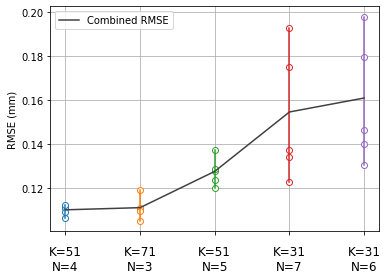

In [187]:
plt.figure(figsize=(5.5, 4.))

df = pd.read_pickle(root / 'results/synth_model_matrix_adam_best_drop.pkl')

filt0 = df['test_rmse'] != ''
filt2 = df['batch_norm'] == True
filt3 = df['pool_step'] == 0
filt = filt0 & filt2  & filt3

df = df[filt].sort_values(['kernel_size']).reset_index(drop=True)
df['test_rmse'] = df['test_rmse'].astype('float')
comb_rmse = []
df_mean = df.groupby('index').mean().sort_values('test_rmse')

comb = []
labels = []
for idx, index in enumerate(df_mean.index.values[:5]):
    df_tmp = df[df['index'] == index]
    test_rmse = df_tmp['test_rmse']
    comb_rmse = np.nanmean(test_rmse**2)**0.5
    comb.append(comb_rmse)
    n_layers, kernel_size = df_tmp[['n_layers', 'kernel_size']].values[0]
    label = f'K={kernel_size}\nN={n_layers}'
    labels.append(label)
    plt.plot(np.ones_like(test_rmse) * (idx+1), test_rmse, 'o', mfc='w', c=f'C{idx}')
    plt.plot([idx+1, idx+1], [test_rmse.min(),  test_rmse.max()], '-', c=f'C{idx}')
plt.plot(range(1, idx+2), comb, '-', c='0.25', label='Combined RMSE')
plt.legend()
plt.xticks([1, 2, 3,4, 5])
plt.ylabel('RMSE (mm)')
plt.gca().set_xticklabels(labels, size=12)
plt.gca().tick_params(axis='x', which='major', pad=10)
plt.grid()
plt.tight_layout()
plt.savefig(figpath / 'repeatability_drop.png', dpi=400)